In [1]:
#ignore if not windows
import winsound

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import helper

In [3]:
nominal_sample = pd.read_csv('samples/2015_nominal_samples_n1.csv')
gray_sample = pd.read_csv('samples/2015_gray_samples_n1.csv')
failure_sample = pd.read_csv('samples/2015_failure_samples_n1.csv')

In [4]:
nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample    = gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample.failure = 1
nominal_sample = nominal_sample.sample(frac=(failure_sample.shape[0]+gray_sample.shape[0])/nominal_sample.shape[0])
data_curr = pd.concat([nominal_sample, failure_sample, gray_sample])
data_curr = data_curr.sample(frac=1)

In [5]:
#normalized
feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

In [6]:
#raw
feature_columns = [ 'smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw',
           'smart_7_raw','smart_12_raw', 'smart_194_raw', 
           'smart_197_raw', 'smart_198_raw', 'smart_199_raw']

In [7]:
scale = 'sk'
train_size = .66

if scale=='sk':
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
elif scale=='sk_manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)

    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        
        scaler = StandardScaler()
        data_sub = scaler.fit_transform(data_sub[feature_columns])
        test_sub = scaler.transform(test_sub[feature_columns])
        
        train_norm = pd.concat([train_norm,pd.DataFrame(data_sub)])
        test_norm = pd.concat([test_norm,pd.DataFrame(test_sub)])
        
        
    x_train = train_norm.sample(frac=1)#[feature_columns]
    x_val = test_norm.sample(frac=1)#[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
elif scale=='manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)
    
    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        max_ = data_sub.max()
        del max_['date']
        min_ = data_sub.min()
        del min_['date']
        for col in feature_columns:
            range_ = max_[col] - min_[col]
            if range_==0:
                range_ = 1
            data_sub[col] = (data_sub[col] - min_[col])/range_
            test_sub[col] = (test_sub[col] - min_[col])/range_
        train_norm = pd.concat([train_norm,data_sub])
        test_norm = pd.concat([test_norm,test_sub])
        
    x_train = train_norm.sample(frac=1)[feature_columns]
    x_val = test_norm.sample(frac=1)[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
    
else:
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# *** MODELS ***
lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(solver='lbfgs')
lr3 = LogisticRegression(solver='saga')
lr4 = LogisticRegression(solver='sag')
lr5 = LogisticRegression(solver='liblinear')

svm_linear = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm_rbf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly = svm.SVC(kernel='poly', gamma='scale', probability=True)
svm_sig = svm.SVC(kernel='sigmoid', gamma='scale', probability=True)

rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
rfc100 = RandomForestClassifier(n_estimators=100)

boost1 = GradientBoostingClassifier(loss='deviance')
boost2 = GradientBoostingClassifier(loss='exponential')

gnb = GaussianNB()
ada = AdaBoostClassifier(gnb, algorithm="SAMME", n_estimators=200,learning_rate=.1)

In [9]:
model_results = {}
#models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, svm_rbf, svm_sig, rfc, rfc100, boost1, boost2, gnb, ada]
models = [lr1, rfc, boost1]

In [10]:
f_rate = 1                 #2856/17509251 are positive  in 2015
n_rate = 17506395/2856     #17506395/17509251 are negative in 2015
print(f_rate,n_rate)
val_sample_weights = compute_sample_weight({1:f_rate,0:n_rate},y_val)

1 6129.69012605042


In [11]:
# *** RUN MODELS ***

for model in models:

    model.fit(x_train, y_train)

    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    eval_v = helper.weighted_evaluation_metrics(pred_val, y_val, val_sample_weights)
    eval_t = helper.evaluation_metrics(pred_train, y_train)
    model_results[model] = {}
    model_results[model]['train'] = eval_t
    model_results[model]['val'] = eval_v
    
# *** RUN MODELS ***

In [12]:
winsound.MessageBeep()

In [13]:
models_plot = [lr1, rfc, boost1]
#models_plot = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, svm_rbf, svm_sig, rfc, rfc100, boost1, boost2, gnb, ada]

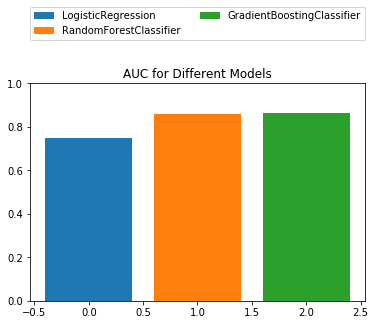

In [14]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("AUC for Different Models")
plt.show()

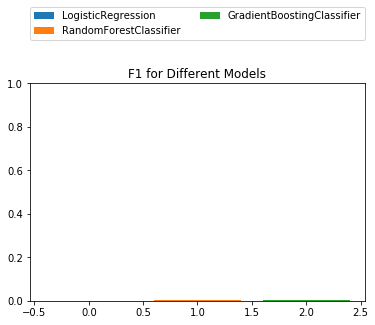

In [15]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

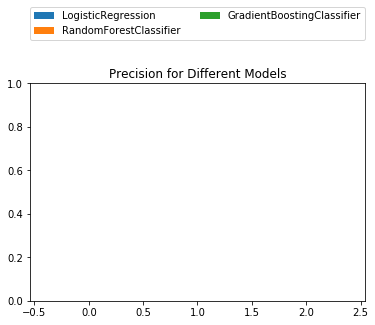

In [16]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Precision for Different Models")
plt.show()

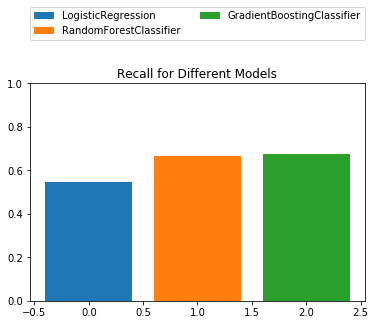

In [17]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Recall for Different Models")
plt.show()

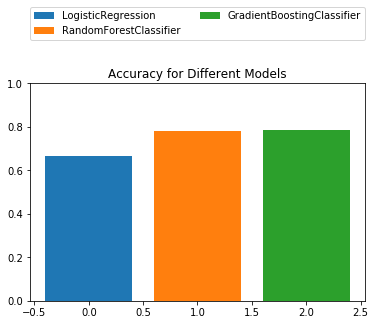

In [18]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

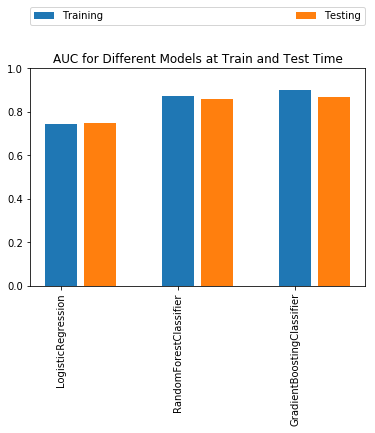

In [19]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

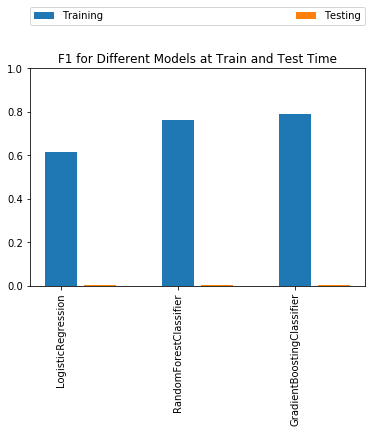

In [20]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

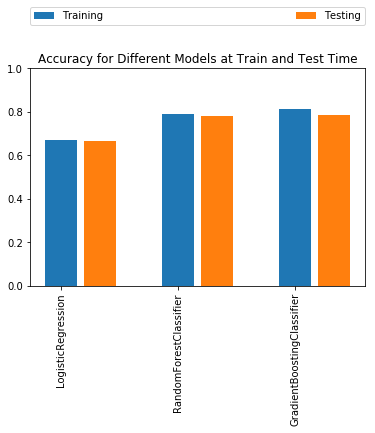

In [21]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

In [22]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('Random Forest',rfc),('Gradient Boosting',boost1)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['accuracy'], model_results[model]['val']['accuracy'],
               model_results[model]['train']['roc_auc'], model_results[model]['val']['roc_auc'],
              model_results[model]['train']['f1'], model_results[model]['val']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training Accuracy','Test Accuracy','Training Auc','Test Auc','Training F1','Test F1']

In [23]:
metrics_


,Training Accuracy,Test Accuracy,Training Auc,Test Auc,Training F1,Test F1
Logistic Regression,0.669617,0.666840,0.740754,0.746861,0.614759,0.000882
Random Forest,0.791097,0.779282,0.873722,0.858827,0.759790,0.002140
Gradient Boosting,0.813087,0.785008,0.901040,0.865440,0.787176,0.002195


In [24]:
# load future
f_nominal_sample = pd.read_csv('samples/2018_nominal_samples_n1.csv')
f_gray_sample = pd.read_csv('samples/2018_gray_samples_n1.csv')
f_failure_sample = pd.read_csv('samples/2018_failure_samples_n1.csv')

#clean future
f_nominal_sample = f_nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_failure_sample = f_failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample    = f_gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample.failure = 1
f_nominal_sample = f_nominal_sample.sample(frac=(f_failure_sample.shape[0]+f_gray_sample.shape[0])/f_nominal_sample.shape[0])

#create test set
data_curr = pd.concat([f_nominal_sample, f_gray_sample, f_failure_sample])
data_curr = data_curr.sample(frac=1)
f_y_test = data_curr['failure']
f_x_test = data_curr[feature_columns]
f_x_test = scaler.transform(f_x_test)

In [25]:
f_rate = 1
n_rate = 17506395/2856 # estimate,, i have no clue irl
print(f_rate,n_rate)
f_sample_weights = compute_sample_weight({1:f_rate,0:n_rate},f_y_test)

1 6129.69012605042


In [26]:
for model in models:
    pred_test = model.predict_proba(f_x_test)[:,1]
    eval_f = helper.weighted_evaluation_metrics(pred_test, f_y_test, f_sample_weights)
    model_results[model]['future'] = eval_f

In [27]:
winsound.MessageBeep()

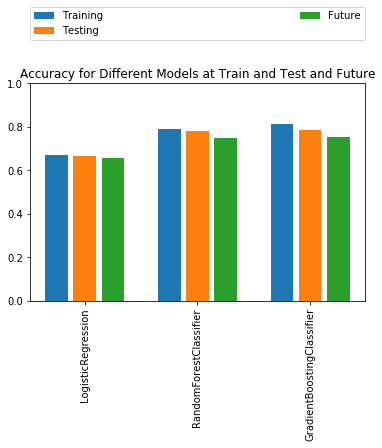

In [28]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
    data_f.append(model_results[model]['future']['accuracy'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

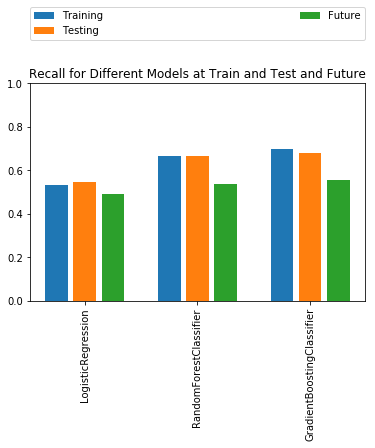

In [29]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['recall'])
    data_v.append(model_results[model]['val']['recall'])
    data_f.append(model_results[model]['future']['recall'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Recall for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [30]:
model_results[models[0]]['val']['confusion'],model_results[models[0]]['future']['confusion']

(array([[4.58500821e+06, 1.20754895e+06],
        [4.43000000e+02, 5.33000000e+02]]),
 array([[9.77072606e+06, 2.07183526e+06],
        [9.88000000e+02, 9.44000000e+02]]))

In [31]:
model_results[models[1]]['val']['confusion'],model_results[models[1]]['future']['confusion']

(array([[5.18571785e+06, 6.06839322e+05],
        [3.25000000e+02, 6.51000000e+02]]),
 array([[1.14073533e+07, 4.35207999e+05],
        [8.97000000e+02, 1.03500000e+03]]))

In [32]:
model_results[models[2]]['val']['confusion'],model_results[models[2]]['future']['confusion']

(array([[5.19184754e+06, 6.00709632e+05],
        [3.15000000e+02, 6.61000000e+02]]),
 array([[1.12234626e+07, 6.19098703e+05],
        [8.63000000e+02, 1.06900000e+03]]))

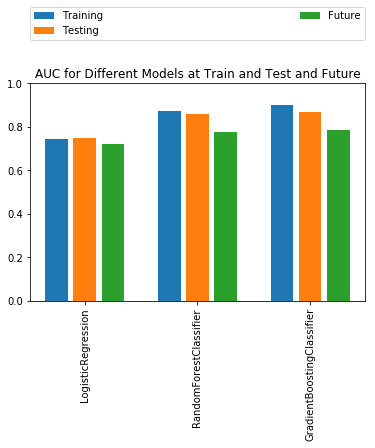

In [33]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
    data_f.append(model_results[model]['future']['roc_auc'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

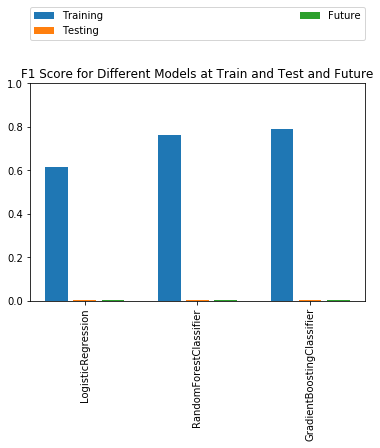

In [34]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
    data_f.append(model_results[model]['future']['f1'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 Score for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

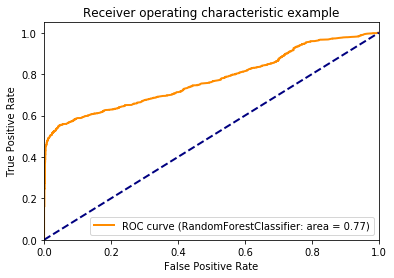

In [35]:
tpr = model_results[models[1]]['future']['tpr']
fpr = model_results[models[1]]['future']['fpr']
auc = model_results[models[1]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(models[1]).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

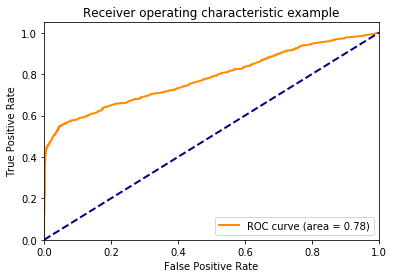

In [36]:
tpr = model_results[models[2]]['future']['tpr']
fpr = model_results[models[2]]['future']['fpr']
auc = model_results[models[2]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

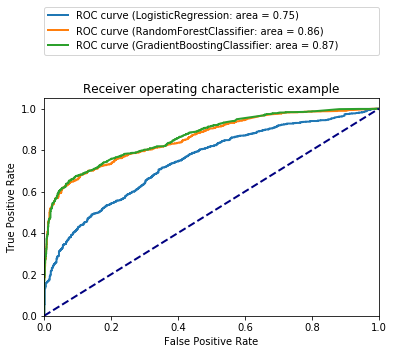

In [37]:
plt.figure()
lw = 2
for mod in models:
    tpr = model_results[mod]['val']['tpr']
    fpr = model_results[mod]['val']['fpr']
    auc = model_results[mod]['val']['roc_auc']
    plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(mod).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score, f1_score


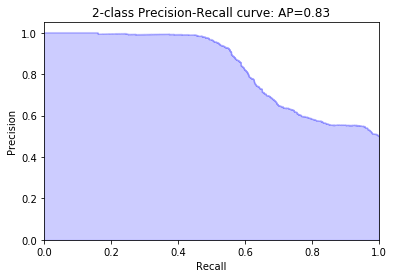

In [39]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
average_precision = average_precision_score(f_y_test, f_y_score)
precision, recall, _ = precision_recall_curve(f_y_test, f_y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [40]:
from sklearn.metrics import f1_score

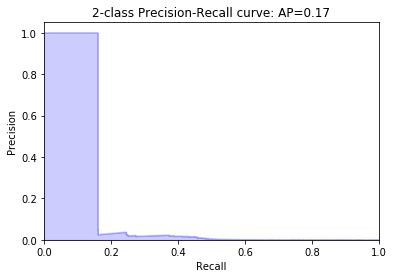

In [43]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
average_precision = average_precision_score(f_y_test, f_y_score, sample_weight=f_sample_weights)
precision, recall, _ = precision_recall_curve(f_y_test, f_y_score, sample_weight=f_sample_weights)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [44]:
from sklearn.metrics import roc_curve,auc,confusion_matrix

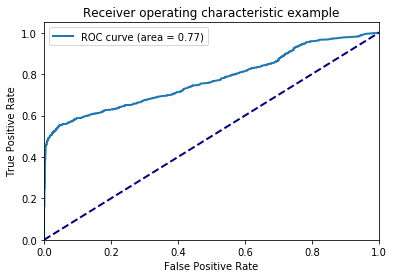

In [45]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
fpr, tpr, thresholds = roc_curve(f_y_test, f_y_score, sample_weight=f_sample_weights)
plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import precision_score,recall_score,roc_curve

In [47]:
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        fpr,tpr,_ = roc_curve(f_y_test,f_y_score)
        print("AUC",auc(fpr,tpr))
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        ap = average_precision_score(f_y_test,f_y_score,sample_weight=f_sample_weights)
        print("AP",ap)


AUC 0.7194339692398698
AUC 0.7733681453047507
AUC 0.7824377703192177
AP 0.07985791373006347
AP 0.1677612243428309
AP 0.11668687887953706


In [49]:
for thres in (np.arange(0,1,.1)):
    print(thres)
    for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        #print(confusion_matrix(f_y_test,1*(f_y_score>thresh),sample_weight=f_sample_weights))
        print("Precision",precision_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))
        print("Recall",recall_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))
        print("F1",f1_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))

0.0
Precision 0.00016311377339899103
Recall 1.0
F1 0.0003261743432700653
Precision 0.00016311377339899103
Recall 1.0
F1 0.0003261743432700653
Precision 0.00016311377339899103
Recall 1.0
F1 0.0003261743432700653
0.1
Precision 0.00016311377339899103
Recall 1.0
F1 0.0003261743432700653
Precision 0.00016311377339899103
Recall 1.0
F1 0.0003261743432700653
Precision 0.00016430917529026414
Recall 0.9958592132505176
F1 0.0003285641400032142
0.2
Precision 0.00016311377339899103
Recall 1.0
F1 0.0003261743432700653
Precision 0.0001816636283630568
Recall 0.9730848861283644
F1 0.0003632594404143781
Precision 0.00018289643606326597
Recall 0.9616977225672878
F1 0.00036572331857557405
0.30000000000000004
Precision 0.00016922388888347085
Recall 0.9746376811594203
F1 0.00033838902413189757
Precision 0.00019857096254990872
Recall 0.9477225672877847
F1 0.0003970587316239534
Precision 0.00021461233145323987
Recall 0.8799171842650103
F1 0.000429120000279837
0.4
Precision 0.00024192476315564954
Recall 0.7577

In [ ]:
thresh = .5
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    print(confusion_matrix(y_val,1*(y_score>thresh),sample_weight=sample_weights))
    print(precision_score(y_val,1*(y_score>thresh),sample_weight=sample_weights))
    print(recall_score(y_val,1*(y_score>thresh),sample_weight=sample_weights))

In [ ]:
help(average_precision_score)

1428 failures / 17509251 total samples
Actually {} failures 2856
Out of {} 17509251
So {} non failures 17506395